KaggleHub est utilisé pour télécharger les données depuis le dataset Kaggle "Fake and Real News Dataset".

In [ ]:
import kagglehub
clmentbisaillon_fake_and_real_news_dataset_path = kagglehub.dataset_download('clmentbisaillon/fake-and-real-news-dataset')

print('Data source import complete.')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

100%|██████████| 41.0M/41.0M [00:02<00:00, 19.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
# Charger les datasets
true_csv_path = os.path.join(clmentbisaillon_fake_and_real_news_dataset_path, 'True.csv')
fake_csv_path = os.path.join(clmentbisaillon_fake_and_real_news_dataset_path, 'Fake.csv')

**1. Importation des bibliothèques et configuration de l'environnement**

In [ ]:
# Installer les bibliothèques manquantes si nécessaire
!pip install datasets

# Importer les bibliothèques essentielles
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Importer Transformers et datasets
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


**2. Chargement et préparation des données**

In [ ]:
# Charger les jeux de données
true = pd.read_csv(true_csv_path)
fake = pd.read_csv(fake_csv_path)

In [ ]:
true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:

# Ajouter des catégories : 0 pour True News, 1 pour Fake News
true['category'] = 0
fake['category'] = 1

In [ ]:

# Combiner les datasets
df = pd.concat([true, fake]).reset_index(drop=True)

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


Une fonction visualize_data_distribution génère un graphique circulaire montrant la répartition des vraies et fausses nouvelles.

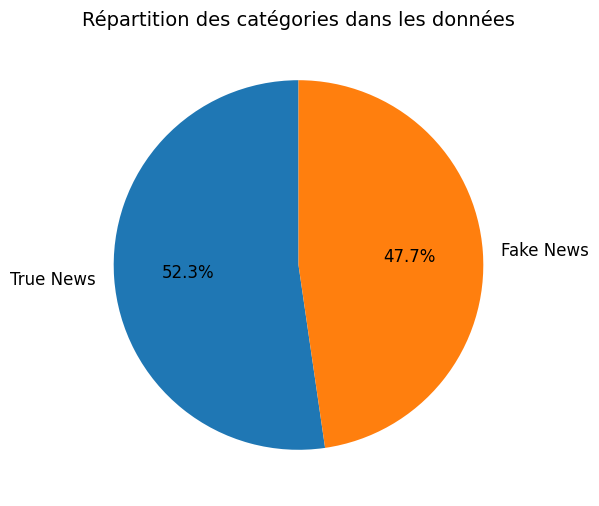

In [ ]:
# Visualisation des catégories
def visualize_data_distribution(data):
    category_counts = data['category'].value_counts()
    labels = ['True News', 'Fake News']
    plt.figure(figsize=(6, 6))
    plt.pie(category_counts, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
    plt.title('Répartition des catégories dans les données', fontsize=14)
    plt.show()

visualize_data_distribution(df)


In [ ]:
#importer
import nltk
nltk.download('stopwords') # telecharger stopwords dataset
nltk.download('wordnet') # telecharger wordnet dataset

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re

#spacy library
nlp=spacy.load("en_core_web_sm")

#create instance
lemma=WordNetLemmatizer()

#Convertit le texte en minuscules.
#Supprime les contractions (ex : I'm → I am).
#Retire les caractères spéciaux et les mots vides (stopwords).
#Effectue une lemmatisation pour normaliser les mots (ex : running → run).


def clean_text(text):

    """
    It takes text as an input and clean it by applying several methods

    """

    string = ""


    text=text.lower()


    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"he's","he is",text)
    text=re.sub(r"she's","she is",text)
    text=re.sub(r"that's","that is",text)
    text=re.sub(r"what's","what is",text)
    text=re.sub(r"where's","where is",text)
    text=re.sub(r"\'ll"," will",text)
    text=re.sub(r"\'ve"," have",text)
    text=re.sub(r"\'re"," are",text)
    text=re.sub(r"\'d"," would",text)
    text=re.sub(r"won't","will not",text)
    text=re.sub(r"can't","cannot",text)

    text=re.sub(r"[-()\"#!@$%^&*{}?.,:]"," ",text)
    text=re.sub(r"\s+"," ",text)
    text=re.sub('[^A-Za-z0-9]+',' ', text)

    Stopwords = set(stopwords.words('english'))

    for word in text.split():
        if word not in Stopwords:
            string+=lemma.lemmatize(word)+" "

    return string

df["text"]=df["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**3. Visualisation exploratoire**


Des nuages de mots sont générés pour les vraies et les fausses nouvelles, en mettant en évidence les mots les plus fréquents.

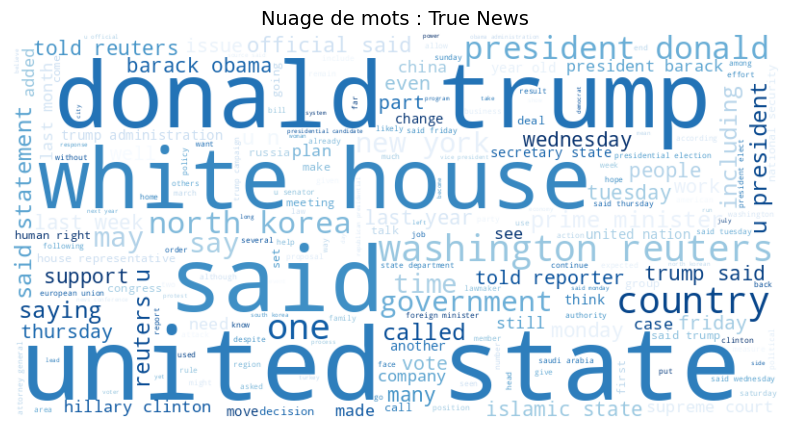

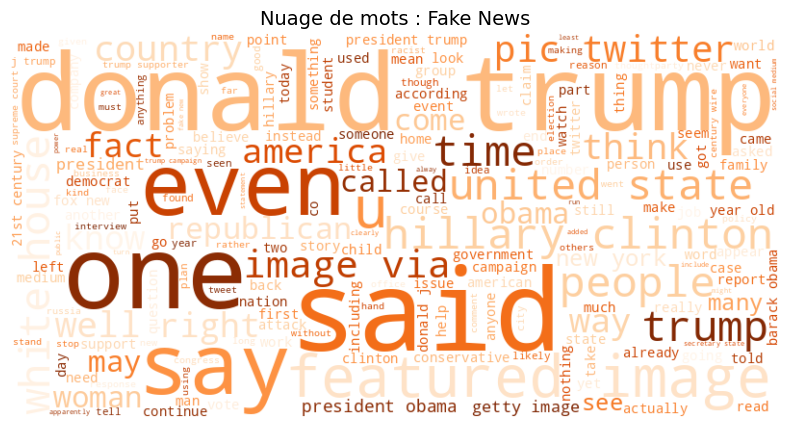

In [ ]:
# Nuage de mots pour chaque catégorie
def generate_word_cloud(data, category_label, title, color):
    category_data = data[data['category'] == category_label]
    text = " ".join(article for article in category_data['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, max_words=200).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

generate_word_cloud(df, 0, "Nuage de mots : True News", "Blues")
generate_word_cloud(df, 1, "Nuage de mots : Fake News", "Oranges")


Un diagramme en barres montre la distribution des catégories et des sujets dans le dataset.

<ipython-input-46-4503be38273e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=category_counts.values, palette=['#1f77b4', '#ff7f0e'])


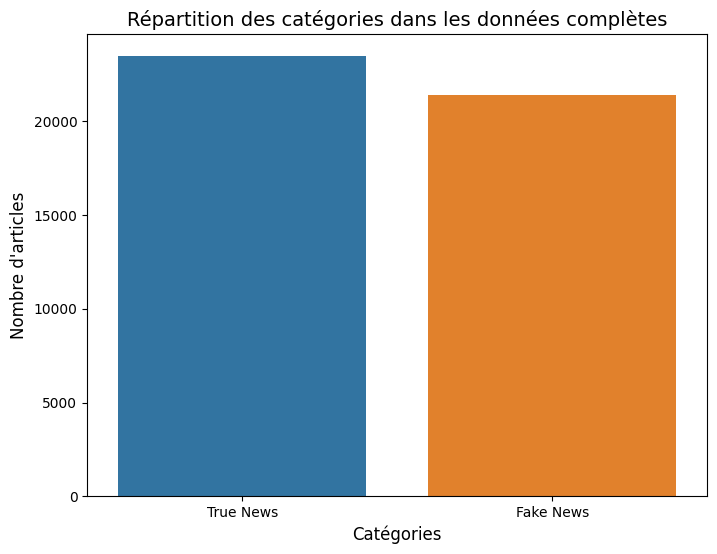

In [ ]:
# Diagramme en barres pour les catégories
def visualize_bar_chart(data, title):
    category_counts = data['category'].value_counts()
    labels = ['True News', 'Fake News']

    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=category_counts.values, palette=['#1f77b4', '#ff7f0e'])
    plt.title(title, fontsize=14)
    plt.xlabel('Catégories', fontsize=12)
    plt.ylabel('Nombre d\'articles', fontsize=12)
    plt.show()

# Visualisation pour les ensembles combinés, d'entraînement et de test
visualize_bar_chart(df, "Répartition des catégories dans les données complètes")


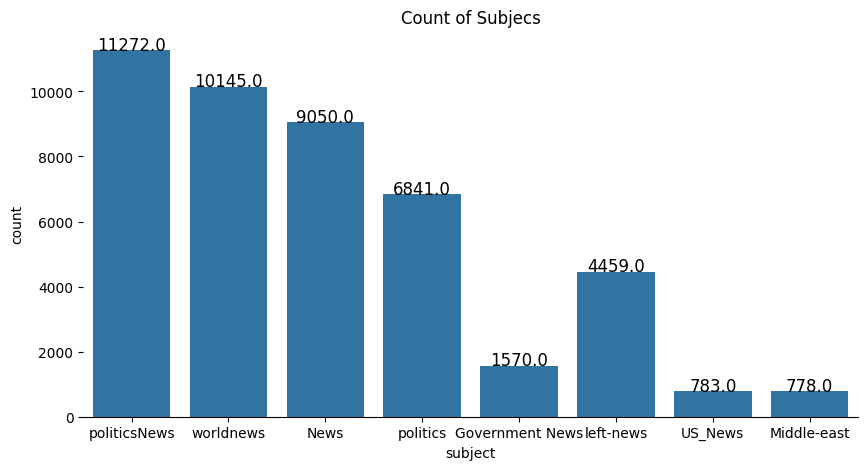

In [ ]:
#creating a count plot for subject column
fig = plt.figure(figsize=(10,5))



graph = sns.countplot(x="subject", data=df)
plt.title("Count of Subjecs")

#removing boundary
graph.spines["right"].set_visible(False)
graph.spines["top"].set_visible(False)
graph.spines["left"].set_visible(False)

#annoting bars with the counts
for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.2,height ,ha="center",fontsize=12)

**4. Préparation pour RoBERTa**

In [ ]:
# Séparer les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)
train_df = train_df.sample(2000, random_state=42)  # Échantillons pour l'entraînement
test_df = test_df.sample(500, random_state=42)    # Échantillons pour le test

# Convertir en format Dataset pour Transformers
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True, max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Renommer et reformater les colonnes
train_dataset = train_dataset.rename_column("category", "labels")
test_dataset = test_dataset.rename_column("category", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

**5. Entraînement du modèle**


In [ ]:
# Charger le modèle pré-entraîné
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Configurer les paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

# Fonction de calcul des métriques
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Entraîner le modèle
trainer.train()


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.071900,0.037299,0.996000,0.992308,1.000000,0.996139
2,0.032800,0.033028,0.996000,0.992308,1.000000,0.996139


TrainOutput(global_step=1000, training_loss=0.0523543815612793, metrics={'train_runtime': 7631.9847, 'train_samples_per_second': 0.524, 'train_steps_per_second': 0.131, 'total_flos': 263111055360000.0, 'train_loss': 0.0523543815612793, 'epoch': 2.0})

6. Évaluation des performances


Précision : 0.9923
Rappel : 1.0000
F1-score : 0.9961
Exactitude : 0.9960


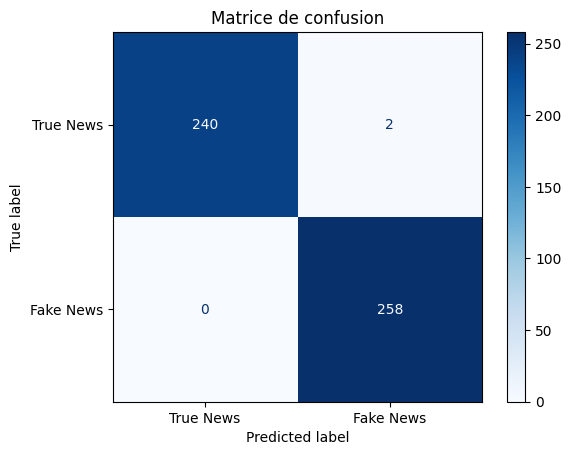

In [ ]:
# Évaluation du modèle
results = trainer.evaluate(test_dataset)
print(f"Précision : {results['eval_precision']:.4f}")
print(f"Rappel : {results['eval_recall']:.4f}")
print(f"F1-score : {results['eval_f1']:.4f}")
print(f"Exactitude : {results['eval_accuracy']:.4f}")

# Matrice de confusion
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True News", "Fake News"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion")
plt.show()


In [14]:
!git clone https://github.com/maryem-elloumi/Detection-fake-news.git

fatal: destination path 'Detection-fake-news' already exists and is not an empty directory.


In [15]:
!pip install geopandas